# Depletion of a Hexagonal Assembly


This notebook is intended to introduce the reader to the contained in ROBIN3. We will convert the hexagonal assembly model built in "Modeling a Single Hexagonal Assembly" example to an OpenMC model.
If you are not familiar with OpenMC's depletion interface or even Python, skip the first two sections in this jupyter notebook, use command line instead and jump to the post-processing part.

In [1]:
import openmc
import robin3
from robin3 import openmc_compatible
from IPython.display import Image

## Create OpenMC Model

Firstly, load pre-defined model in ["Modeling a Single Hexagonal Assembly" example](hexagonal_assembly.ipynb). You can find the input file in examples folder under root directory of ROBIN3's source. Then append parameters used by openmc_compatible module (this step is optional, we can just use the default parameters).

We have input and output of ROBIN3 in the current working directory.

In [2]:
!ls

hexagonal_assembly.yaml  single_hexagonal_assembly.h5


In [3]:
# Read model from input file
robin3_model = robin3.utils.load_data_from_file('hexagonal_assembly.yaml')[1]

Add openmc_compatible parameters to model dictionary. In this example, we choose to tally pin power and homogenized cross-section of the assembly.

In [4]:
# Add openmc_compatible parameters to model dictionary
parameters = {'volume':'openmc', 'optimize':True, }
tallies = ['pin-power', 'cross-section']
parameters['tallies'] = tallies
robin3_model['openmc_compatible'] = parameters

Because we've set OpenMC to calculate volumes (used to deduce power density), the OpenMC executable will be launched in volume calculation mode during model conversion.

In [5]:
openmc_model = openmc_compatible.get_model(robin3_model)

No protocol specified
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                

Now we have an OpenMC model. It is strongly recommended to use [OpenMC Plot Explorer](https://github.com/openmc-dev/plotter) for plotting geometry, which is much faster than OpenMC Python API's built-in plot function. The following figure shows the geometry plotted in OpenMC Plot Explorer GUI, which is identical to ROBIN3 model(except color XD).

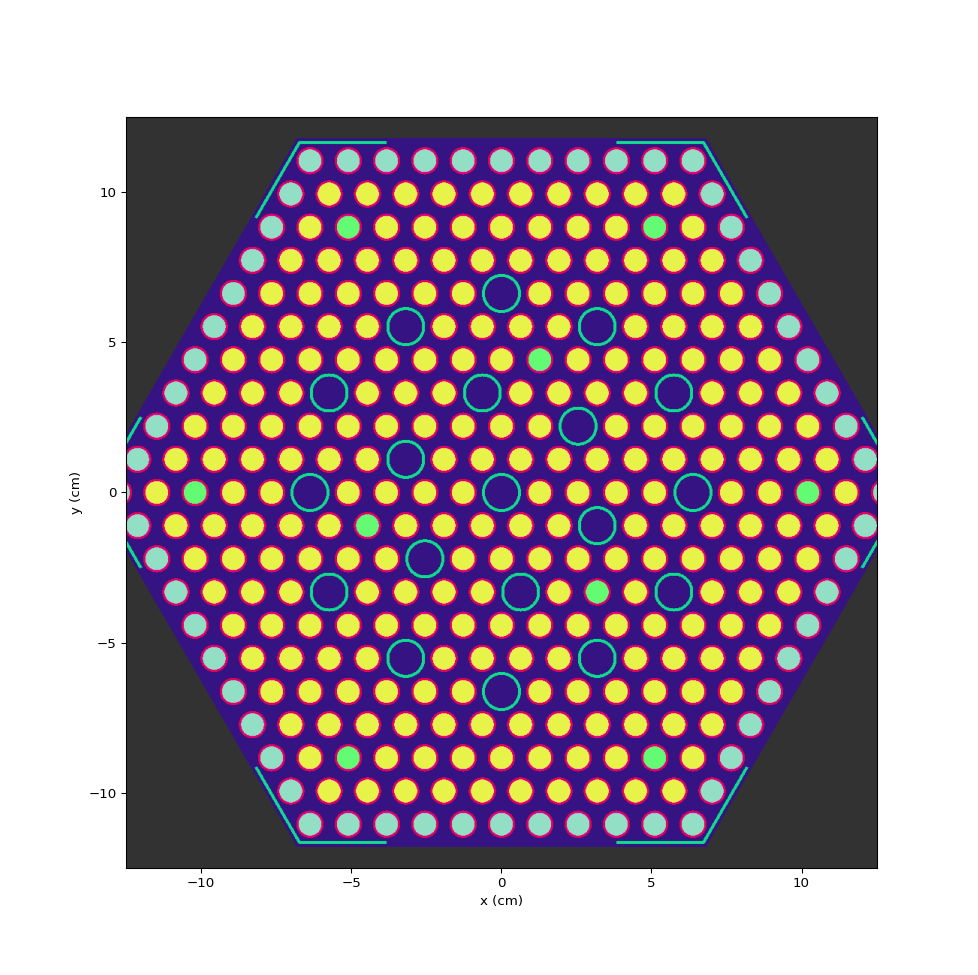

In [6]:
Image('./images/39AWU.png', width=600)

## Setting Up for Depletion

The OpenMC depletion interface can be accessed from the `openmc.deplete` module. The official document of OpenMC has introduced relevant usage and examples in detail. Here we will just use a method provided by `robin3.openmc_compatible`, which groups some empirical parameters, to generate an `openmc.deplete.CECMIntegrator`.

In [8]:
geometry = openmc_model.geometry
settings = openmc_model.settings
depletion_states = robin3_model["state_points"]

In [9]:
intergrator = openmc_compatible.get_depletion_integrator(geometry, settings, depletion_states)

In [10]:
intergrator.intergrate()

## Processing the Outputs

ROBIN3's OpenMC Compatibility module has also provided methods for processing and compare results between ROBIN3 and OpenMC.

In [11]:
# Load ROBIN3 and OpenMC depletion results
robin3_result = robin3.ResultProcessor("single_hexagonal_assembly.h5")
openmc_result = openmc.deplete.ResultsList.from_hdf5("depletion_results.h5")

`openmc_compatible.process_eigenvalues` method compares evolution of keff in depletion calculated by ROBIN3 and OpenMC. We can see from the figure below that the results are in good agreement.

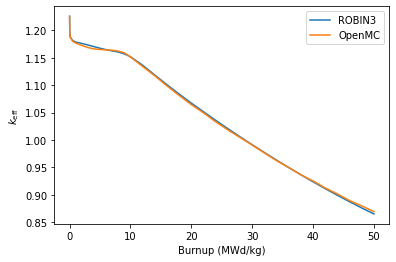

In [12]:
openmc_compatible.process_eigenvalues(openmc_result,robin3_result)

Then we use `openmc_compatible.process_pin_power` method to plot pin power distribution difference between OpenMC and ROBIN3. We can see that all the pin power are in good agreement except the pins containing gadolinium. Because ROBIN3 will count energy release by (n,γ) reaction in gadolinium while OpenMC only tally power from fission reaction.

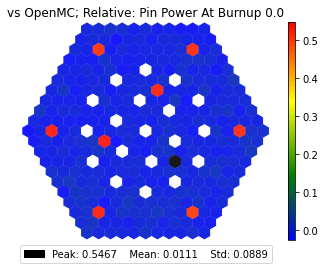

In [13]:
statepoint = openmc.StatePoint("openmc_simulation_n0.h5")
fig = openmc_compatible.process_pin_power(statepoint,robin3_result)

Finally, `openmc_compatible.generate_xs_library` can create a two-group cross-section library with homogenized cross sections of the assembly.

In [14]:
xs_lib = openmc_compatible.generate_xs_library(statepoint=statepoint)
root = statepoint.summary.geometry.root_universe


In [15]:
fission_xs = xs_lib.get_mgxs(root,'fission')
fission_xs.get_pandas_dataframe()

,universe,group in,nuclide,mean,std. dev.
1,106,1,total,0.002954,0.000002
0,106,2,total,0.063329,0.000070


In [14]:
scatter_xs = xs_lib.get_mgxs(root,'scatter matrix')
scatter_xs.get_pandas_dataframe()

,universe,group in,group out,nuclide,mean,std. dev.
3,106,1,1,total,0.278466,0.000256
2,106,1,2,total,0.015938,0.000015
1,106,2,1,total,0.001837,0.000011
0,106,2,2,total,0.825945,0.002247
